In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3) # i/p 28x28x1  10x3x3x1 >> o/p 26x26x10 RF 1
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3) # i/p 26x26x10  10x3x3x10 >>o/p 24x24x10 RF 3
    self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3) # i/p 24x24x10  10x3x3x10x20 >>o/p 22x22x20 RF 5
    self.pool1 = nn.MaxPool2d(2, 2)  #i/p 22x22x20 >> o/p 11x11x20 RF 10
    self.conv4 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3) # i/p 11x11x20  10x3x3x10x20x20  >>o/p 9x9x20 RF 12
    self.conv5 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3) # i/p 9x9x20 >> 10x3x3x10x20x20x30 >>o/p 7x7x30 RF 14    
    self.pool2 = nn.MaxPool2d(2, 2)  # ip 7x7x30  >> o/p 3x3x30 RF 28
    self.conv6 = nn.Conv2d(in_channels=30, out_channels=62  , kernel_size=3) # i/p 7x7x30 >>  10x3x3x10x20x20x30x62    >> o/p 5x5x62  RF 30
     

  def forward(self, x):
    x = self.pool1(F.relu(self.conv3(F.relu(self.conv2(F.relu(self.conv1(x)))))))   # relu layer drops all negative values and propagates positive values as it is
    x = self.pool2(F.relu(self.conv5(F.relu(self.conv4(x)))))
    x = self.conv6(x)  
    x = x.view(-1, 62)
    return F.log_softmax(x)

In [3]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
            Conv2d-2           [-1, 10, 24, 24]             910
            Conv2d-3           [-1, 20, 22, 22]           1,820
         MaxPool2d-4           [-1, 20, 11, 11]               0
            Conv2d-5             [-1, 20, 9, 9]           3,620
            Conv2d-6             [-1, 30, 7, 7]           5,430
         MaxPool2d-7             [-1, 30, 3, 3]               0
            Conv2d-8             [-1, 62, 1, 1]          16,802
Total params: 28,682
Trainable params: 28,682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.11
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', train=True, download=True,split='byclass',
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', train=False, split='byclass',transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/EMNIST/raw/emnist.zip to ../data/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [5]:
n_batch = next(iter(train_loader))
len(n_batch), type(n_batch)

images = n_batch[0]
labels = n_batch[1]
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([53, 24, 24,  5,  6, 49,  1, 29,  3, 28, 39, 22, 40, 40, 32,  3, 20,  6,
         0,  8,  0, 39, 20, 45, 55, 47,  5, 39,  1,  9,  0, 24, 24, 36,  0,  8,
         8, 39,  6,  2,  4,  9,  7, 14,  6,  1, 40, 24, 10, 27, 55, 53,  4, 32,
         7,  9, 40, 43,  5, 24,  9,  6,  4,  0, 20, 14,  8,  6,  4,  2,  2, 29,
        24, 36,  1, 34,  8, 18, 28,  6,  6, 30, 55, 55, 39, 48,  2, 49, 32, 29,
         4, 25,  8, 47, 22, 28, 58, 42, 28,  7, 29, 50, 25, 38, 28, 36,  1,  1,
        48, 38, 24,  2,  8, 53,  9,  7, 15,  9, 32, 37,  0, 39, 21,  2, 55, 12,
        55,  5])


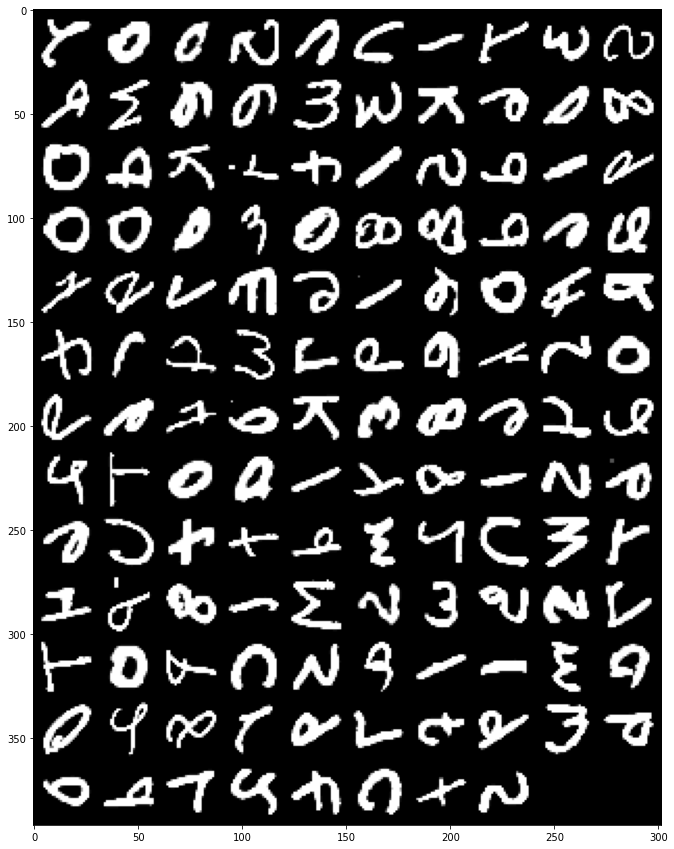

In [6]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

In [7]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/5453 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.3481062650680542 batch_id=5452 Accuracy=79.48: 100%|██████████| 5453/5453 [02:41<00:00, 33.81it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.4740, Accuracy: 96982/116323 (83%)

EPOCH: 1


loss=0.48537150025367737 batch_id=5452 Accuracy=84.19: 100%|██████████| 5453/5453 [02:40<00:00, 34.04it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.4267, Accuracy: 98672/116323 (85%)

EPOCH: 2


loss=0.47311797738075256 batch_id=5452 Accuracy=84.92: 100%|██████████| 5453/5453 [02:40<00:00, 33.95it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.4147, Accuracy: 99030/116323 (85%)

EPOCH: 3


loss=0.30977150797843933 batch_id=5452 Accuracy=85.31: 100%|██████████| 5453/5453 [02:40<00:00, 33.95it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.4084, Accuracy: 98989/116323 (85%)

EPOCH: 4


loss=0.22966718673706055 batch_id=5452 Accuracy=85.60: 100%|██████████| 5453/5453 [02:41<00:00, 33.75it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.4017, Accuracy: 99130/116323 (85%)

EPOCH: 5


loss=0.5807479023933411 batch_id=5452 Accuracy=85.81: 100%|██████████| 5453/5453 [02:42<00:00, 33.54it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3966, Accuracy: 99421/116323 (85%)

EPOCH: 6


loss=0.3874308168888092 batch_id=5452 Accuracy=85.91: 100%|██████████| 5453/5453 [02:42<00:00, 33.47it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3979, Accuracy: 99499/116323 (86%)

EPOCH: 7


loss=0.2421533614397049 batch_id=5452 Accuracy=86.00: 100%|██████████| 5453/5453 [02:42<00:00, 33.49it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3871, Accuracy: 100021/116323 (86%)

EPOCH: 8


loss=0.3167347013950348 batch_id=5452 Accuracy=86.15: 100%|██████████| 5453/5453 [02:43<00:00, 33.35it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3884, Accuracy: 99776/116323 (86%)

EPOCH: 9


loss=0.3772448003292084 batch_id=5452 Accuracy=86.21: 100%|██████████| 5453/5453 [02:45<00:00, 32.96it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3818, Accuracy: 100204/116323 (86%)

EPOCH: 10


loss=0.35836708545684814 batch_id=5452 Accuracy=86.28: 100%|██████████| 5453/5453 [02:46<00:00, 32.78it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3846, Accuracy: 100121/116323 (86%)

EPOCH: 11


loss=0.35836875438690186 batch_id=5452 Accuracy=86.37: 100%|██████████| 5453/5453 [02:44<00:00, 33.14it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3786, Accuracy: 100190/116323 (86%)

EPOCH: 12


loss=0.31063389778137207 batch_id=5452 Accuracy=86.41: 100%|██████████| 5453/5453 [02:52<00:00, 31.57it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3796, Accuracy: 100271/116323 (86%)

EPOCH: 13


loss=0.3432072699069977 batch_id=5452 Accuracy=86.44: 100%|██████████| 5453/5453 [02:51<00:00, 31.75it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3811, Accuracy: 100097/116323 (86%)

EPOCH: 14


loss=0.35666802525520325 batch_id=5452 Accuracy=86.53: 100%|██████████| 5453/5453 [02:51<00:00, 31.78it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3879, Accuracy: 100029/116323 (86%)

EPOCH: 15


loss=0.20016658306121826 batch_id=5452 Accuracy=86.55: 100%|██████████| 5453/5453 [02:50<00:00, 31.98it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3802, Accuracy: 99990/116323 (86%)

EPOCH: 16


loss=0.3557685911655426 batch_id=5452 Accuracy=86.56: 100%|██████████| 5453/5453 [02:52<00:00, 31.69it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3775, Accuracy: 100289/116323 (86%)

EPOCH: 17


loss=0.33829358220100403 batch_id=5452 Accuracy=86.63: 100%|██████████| 5453/5453 [02:53<00:00, 31.42it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3818, Accuracy: 100101/116323 (86%)

EPOCH: 18


loss=0.3454602360725403 batch_id=5452 Accuracy=86.63: 100%|██████████| 5453/5453 [02:54<00:00, 31.27it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.3740, Accuracy: 100346/116323 (86%)

EPOCH: 19


loss=0.3466736674308777 batch_id=5452 Accuracy=86.63: 100%|██████████| 5453/5453 [02:54<00:00, 31.28it/s]



Test set: Average loss: 0.3815, Accuracy: 100173/116323 (86%)

